# 10. Linear Regression

This chapter will introduce you to **linear regression** analysis using R.

### Linear Regression Basics

#### Linear Regression Equation

$\hat{y} = b_0 + b_1x$

#### Model Assumption

The assumptions of linear regression are important to ensure the validity and reliability of the model. Here are five key assumptions:

- Linearity: The relationship between the independent variables and the dependent variable is linear. This means that the change in the dependent variable is proportional to the change in the independent variable(s). It is essential to check for linearity by examining scatter plots or performing diagnostic tests.

- Independence: The observations in the dataset are assumed to be independent of each other. There should be no systematic relationship or correlation between the residuals (the differences between the predicted and observed values). Independence can be violated when there is autocorrelation or when observations are clustered or dependent on each other.

- Homoscedasticity: The variance of the residuals is constant across all levels of the independent variables. In other words, the spread or dispersion of the residuals should remain consistent throughout the range of the independent variable(s). Violations of homoscedasticity, called heteroscedasticity, can lead to biased standard errors and incorrect hypothesis tests.

- Normality: The residuals follow a normal distribution. This assumption allows for valid hypothesis testing, confidence interval estimation, and prediction intervals. Departures from normality can affect the accuracy of statistical inferences, especially when dealing with small sample sizes. However, the central limit theorem helps to mitigate minor departures from normality in large samples.

- No multicollinearity: The independent variables should not be highly correlated with each other. High multicollinearity can lead to unstable and unreliable estimates of the coefficients. It becomes challenging to distinguish the individual effects of the independent variables, and the interpretation of the model becomes problematic. Detecting multicollinearity can be done using correlation matrices or variance inflation factor (VIF) calculations.

We'll discuss how to check these assumptions with R in the later section.

### Linear Regression in R

Temporarily using body measures data from NHANESA as an example.

In [109]:
library('nhanesA')
library('broom')
library('car')
library('tidyverse')
library('MASS')

#### Understanding the variable names

In [3]:
nhanesTableVars('EXAM', 'BMX_D')

,Variable.Name,Variable.Description
,<chr>,<chr>
1,BMDSTATS,Body Measures Component status Code
2,BMIARMC,Arm Circumference Comment
3,BMIARML,Upper Arm Length Comment
4,BMICALF,Maximal Calf Comment
5,BMIHEAD,Head Circumference Comment
6,BMIHT,Standing Height Comment
7,BMILEG,Upper Leg Length Comment
8,BMIRECUM,Recumbent Length Comment
9,BMISUB,Subscapular Skinfold Comment


#### Dropping id column before linear regression analysis

In [6]:
bmx_d  <- nhanes('BMX_D')
head(bmx_d)

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,⋯,BMXARMC,BMIARMC,BMXWAIST,BMIWAIST,BMXTHICR,BMITHICR,BMXTRI,BMITRI,BMXSUB,BMISUB
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,31127,1,10.2,NA,73.6,NA,NA,NA,NA,NA,⋯,15.5,NA,NA,NA,NA,NA,12.8,NA,10.0,NA
2,31128,1,40.1,NA,NA,NA,NA,NA,151.6,NA,⋯,21.7,NA,62.8,NA,39.5,NA,10.4,NA,8.4,NA
3,31129,1,74.6,NA,NA,NA,NA,NA,167.7,NA,⋯,32.6,NA,97.8,NA,55.9,NA,18.8,NA,17.6,NA
4,31130,4,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,31131,3,75.2,NA,NA,NA,NA,NA,156.0,NA,⋯,35.8,NA,96.0,NA,53.7,NA,NA,2,NA,1
6,31132,1,69.5,NA,NA,NA,NA,NA,167.6,NA,⋯,31.2,NA,96.5,NA,48.0,NA,10.4,NA,22.2,NA


#### Plotting the points to see relationship between standing height and uppper leg length

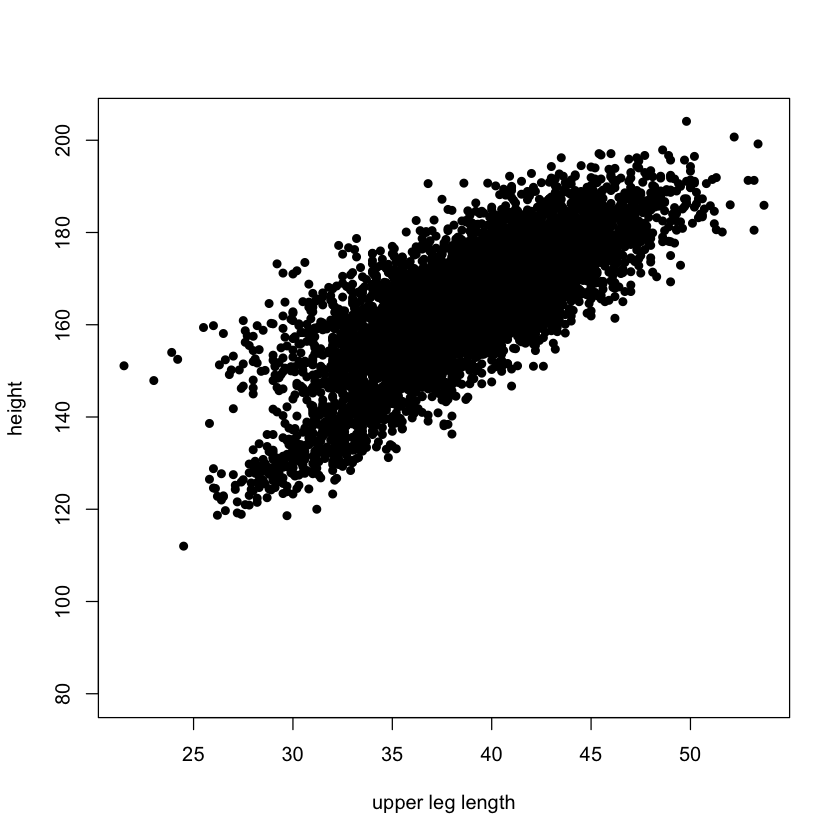

In [23]:
BMXHT <- bmx_d$BMXHT
BMXLEG <-  bmx_d$BMXLEG

plot(BMXHT~BMXLEG,ylab=c("height"),xlab=c("upper leg length"),pch=16)

From the scatterplot, we could see a roughly linear relationship between upper leg length and height

#### Using the basic linear regression function in R

Now fit a regression line to explain the association between upper leg length and height.

The function in R is lm(formula = y ~ x, data)

In [24]:
model <- lm(formula = BMXHT~BMXLEG, data = bmx_d)
summary(model)


Call:
lm(formula = BMXHT ~ BMXLEG, data = bmx_d)

Residuals:
     Min       1Q   Median       3Q      Max 
-26.4959  -5.3493   0.0359   5.2011  31.3934 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  73.3415     0.8471   86.58   <2e-16 ***
BMXLEG        2.3447     0.0217  108.05   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.984 on 7303 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.6152,	Adjusted R-squared:  0.6151 
F-statistic: 1.168e+04 on 1 and 7303 DF,  p-value: < 2.2e-16


Next plot the estimtated regression line over the scatterplot.

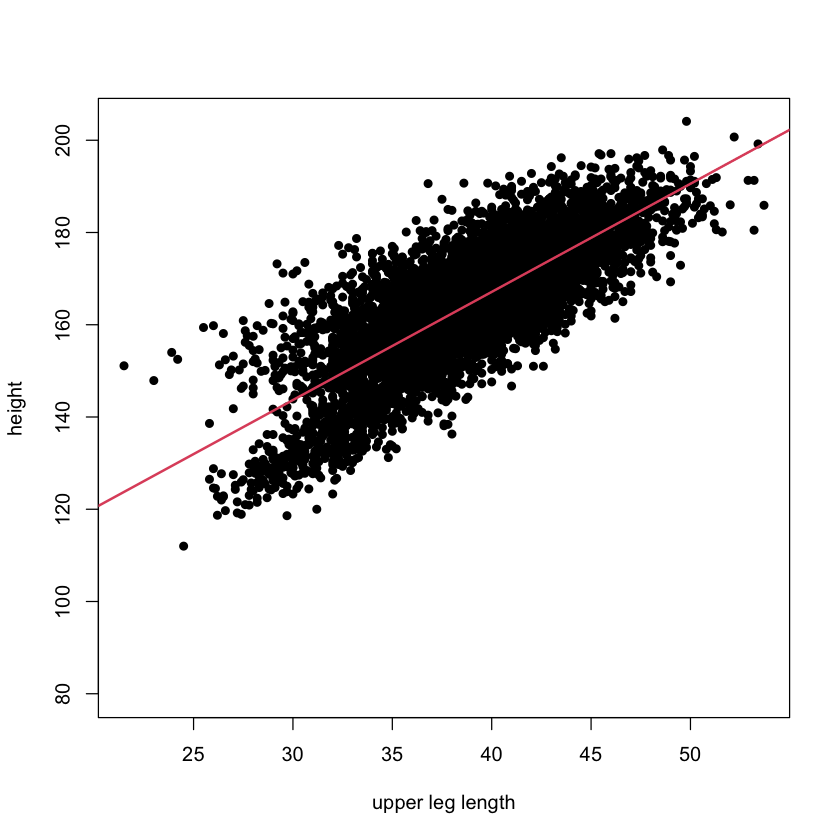

In [25]:
plot(BMXHT~BMXLEG,ylab=c("height"),xlab=c("upper leg length"),pch=16)
abline(model,col=2,lwd=2)

#### Intepretating Linear Regression Result

We can also extract the regression coefficients from the lm() using the following commands, it shows the estimate, standard error, statistic, and p-value of each coefficient in a clean table.

In [28]:
tidy(model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),73.341547,0.84714015,86.57546,0
BMXLEG,2.344692,0.02169975,108.05154,0


#### With categorical variables

We can also examine the relationship between Body Measures Component status Code-a categorical variable represented by numbers, and body height using the function factor().

In [58]:
BMDSTATS <- bmx_d$BMDSTATS

Count unique values in this variable

In [40]:
unique(BMDSTATS)

[1] 1 4 3 2

In [37]:
model2 <- lm(formula = BMXHT~factor(BMDSTATS), data = bmx_d)
summary(model2)


Call:
lm(formula = BMXHT ~ factor(BMDSTATS), data = bmx_d)

Residuals:
    Min      1Q  Median      3Q     Max 
-81.258  -6.858   6.125  15.825  46.525 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       154.1747     0.2833 544.268  < 2e-16 ***
factor(BMDSTATS)2   5.4292     1.8043   3.009  0.00263 ** 
factor(BMDSTATS)3   7.9837     0.6517  12.250  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.91 on 8959 degrees of freedom
  (988 observations deleted due to missingness)
Multiple R-squared:  0.01699,	Adjusted R-squared:  0.01677 
F-statistic:  77.4 on 2 and 8959 DF,  p-value: < 2.2e-16


In order to consider height, upper leg length, and body measures component status code, we can start by creating a scatterplot of height versus upper leg lenth, stratified by body measures component status code.

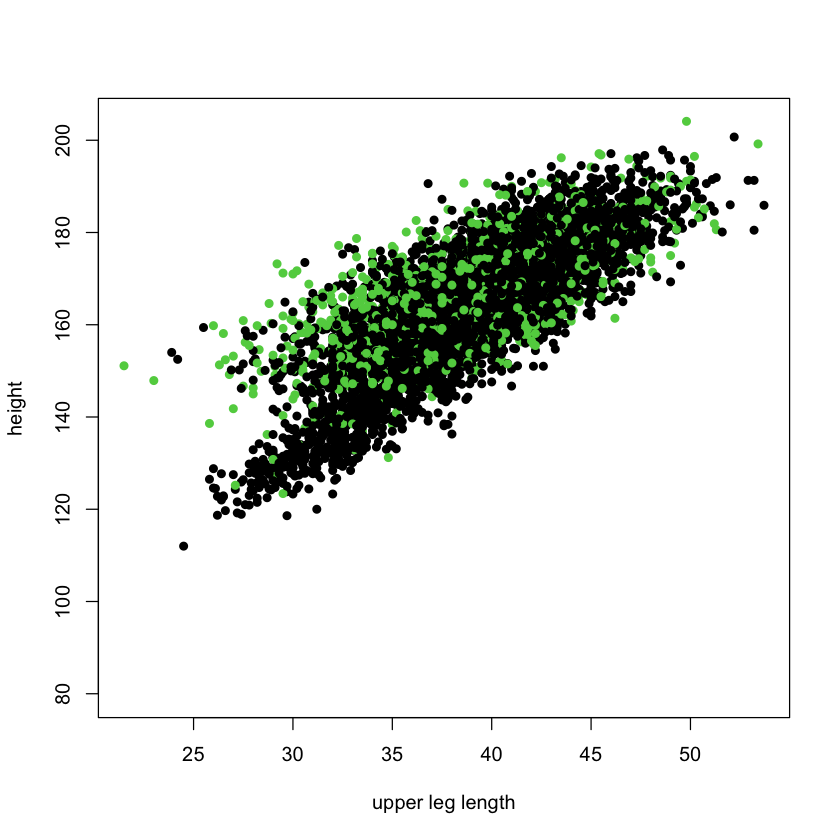

In [57]:
colvec <- c(1,2,3,4) # here define values to define color in plot below 
plot(BMXLEG, BMXHT, pch=16, col = colvec[factor(BMDSTATS)], xlab="upper leg length",ylab="height")

Now lets fit a model to predict height based on upper leg length and body measures comopnent.

In [64]:
model3 <- lm(BMXHT ~ factor(BMDSTATS) + BMXLEG, data = bmx_d)
summary(model3)


Call:
lm(formula = BMXHT ~ factor(BMDSTATS) + BMXLEG, data = bmx_d)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.9438  -5.3149   0.0564   5.2178  31.4871 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       72.57311    0.84322   86.07   <2e-16 ***
factor(BMDSTATS)3  2.56929    0.23426   10.97   <2e-16 ***
BMXLEG             2.35162    0.02153  109.20   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.92 on 7302 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.6214,	Adjusted R-squared:  0.6213 
F-statistic:  5993 on 2 and 7302 DF,  p-value: < 2.2e-16


Last, let’s look at estimating a 95% confidence interval for the coefficient for upper leg length. We can either do it by hand or use the function confint()

In [74]:
t_val <- qt(0.975, 4092) # how to get degrees of freedom?
coef_df <- tidy(model3)
leg_coef_val <- coef_df[3,2] # extracts the estimated coefficient 
leg_se <- coef_df[3,3] # extracts standard error

upper_bound <- leg_coef_val + t_val*leg_se
lower_bound <- leg_coef_val - t_val*leg_se

print(lower_bound)
print(upper_bound)

  estimate
1 2.309407
  estimate
1 2.393843


Note that the function confint() will give confidence interval to all coefficients, including categorical variables.

In [69]:
ci <- confint(model3, level = 0.95)
ci

,2.5 %,97.5 %
(Intercept),70.920149,74.226063
factor(BMDSTATS)3,2.110070,3.028510
BMXLEG,2.309412,2.393838


#### Checking Model Assumptions with R

R has some built-in plots available for a linear regression model. We plot these below. The four plots include (a) Residuals vs Fitted, (b) QQ-plot, (c) Standardized residuals (sqrt) vs Fitted, and (d) Standardized residuals vs leverage. In the last plot, you may observe that there is a dashed line. Any points outside of these lines have a Cook’s distance of greater than 0.5. Additionally, points with labels correspond to the points with the largest residuals. So this last plot tries to summarize the outliers, leverage, and influential
points.


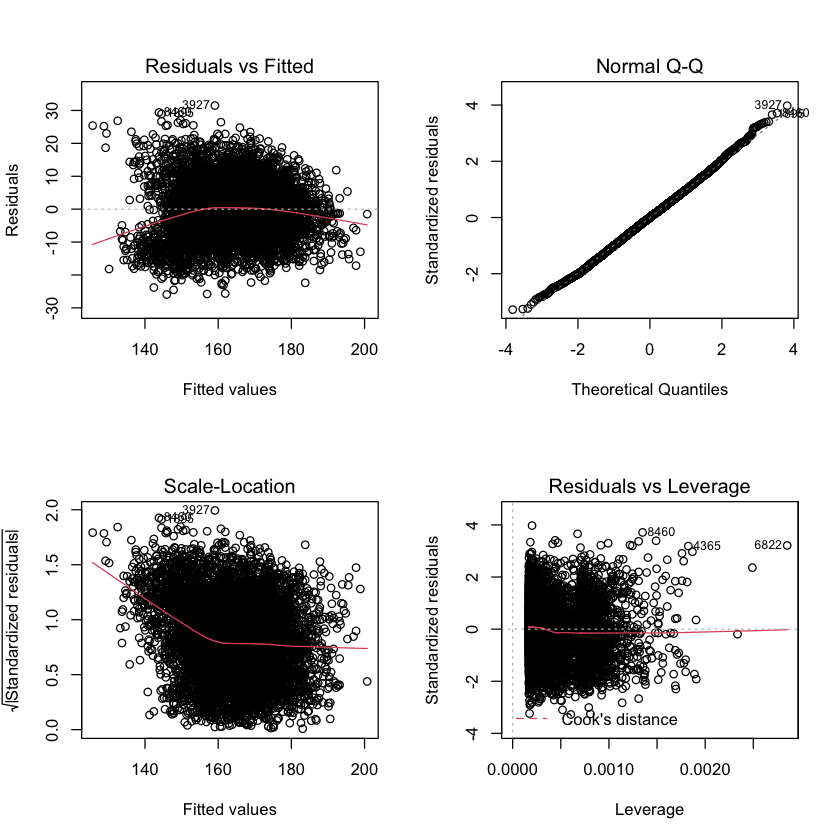

In [81]:
par(mfrow=c(2,2)) # for formatting
plot(model3)

##### Normality

As both the histogram and qq plot shown, the residuals are roughly normally distributed, and thus Normality satisfied.

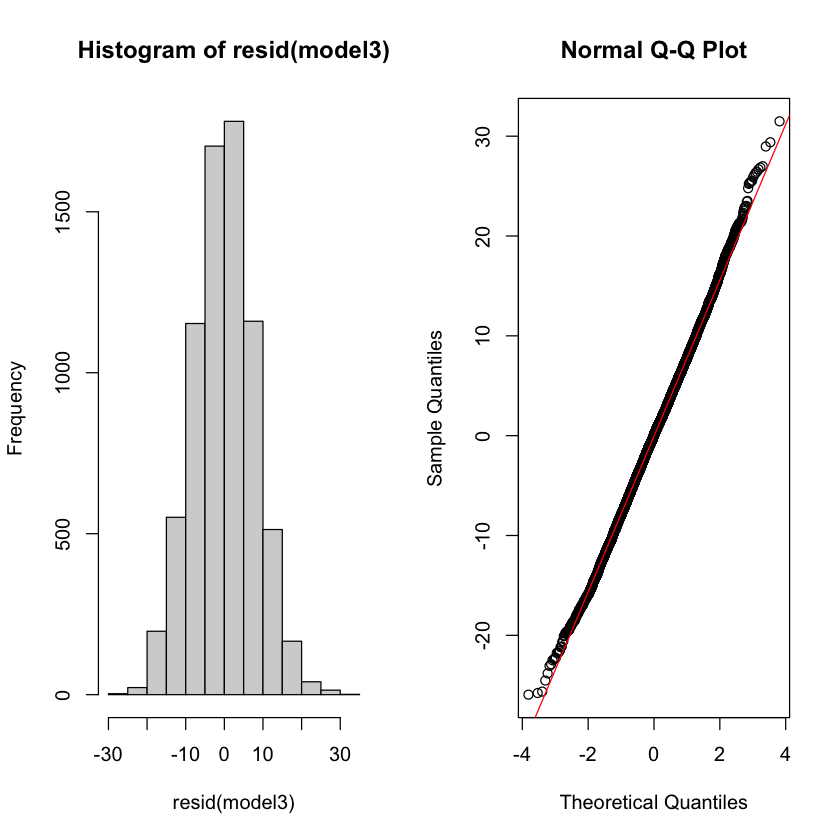

In [80]:
par(mfrow=c(1,2)) # for formatting
hist(resid(model3)) # hist() is used to plot histogram, resid() is used to get residuals of the model
qqnorm(resid(model3)) # qqnorm() is used to plot qq plot
qqline(resid(model3),col="red") # qqline is used to draw the normal qq line as reference

We could also check normality without using the function resid(). We could calculate the standardized residual using the function rstandard(), and then use the standardized residual to check.

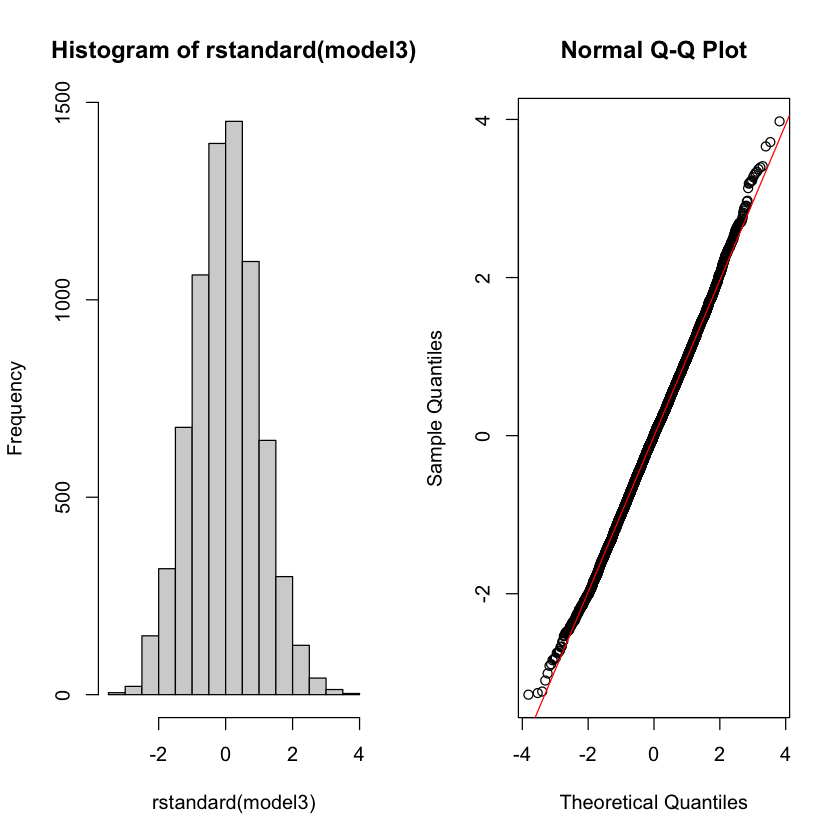

In [92]:
par(mfrow=c(1,2)) 
hist(rstandard(model3)) 
qqnorm(rstandard(model3)) 
qqline(rstandard(model3),col="red")

##### homoscedasticity and Linearity

The fitted vs. residual plot is spread roughly evenly around 0 and has no discerning pattern, and thus fit the linearity assumption. However, the residual vs. fitted value graph shows a tunnel shape, indicating a shrinking variance of residuals, and is thus, violating homoscedasticity assumption.

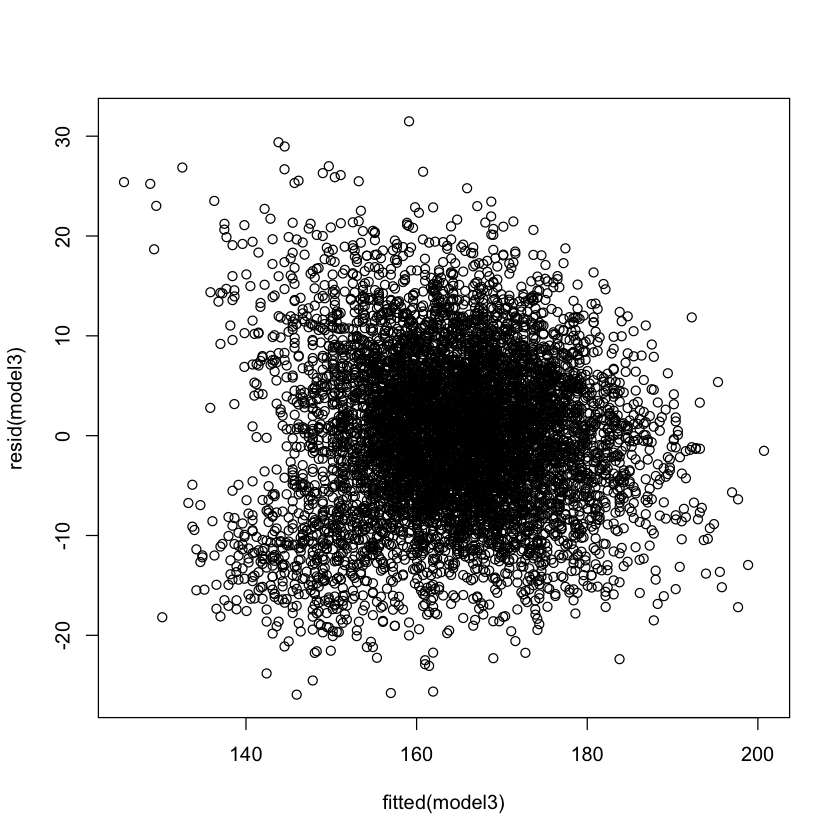

In [82]:
par(mfrow=c(1,1))
plot(fitted(model3), resid(model3))

##### collinearity

VIF = 1 → complete absence of collinearity 

VIF ≥ 5 or 10 → problematic amount of collinearity

In [89]:
vif(model3)

factor(BMDSTATS)           BMXLEG 
        1.000862         1.000862

##### leverage

Leverage values measure how much an individual observation's predictor values differ from the average predictor values in the dataset. High leverage values indicate that an observation has extreme predictor values compared to the rest of the data.

Leverage values range from 0 to 1, with higher values indicating greater influence. Observations with high leverage have the potential to significantly impact the estimated regression coefficients and the overall fit of the model. Therefore, examining leverage values helps identify observations that may be influential or outliers.

In [94]:
hatvalues(model3)

2            3            5            6            7            8 
0.0001817189 0.0002787556 0.0007064115 0.0001873847 0.0001707624 0.0002213254 
          10           12           13           14           16           17 
0.0010317608 0.0007385956 0.0001794782 0.0002102946 0.0009446335 0.0001851863 
          18           19           21           22           23           24 
0.0001955860 0.0004416936 0.0001873847 0.0002486423 0.0002787556 0.0003106594 
          25           26           27           28           29           30 
0.0003594398 0.0007351058 0.0001782794 0.0003089687 0.0007057639 0.0003825634 
          31           32           33           34           35           36 
0.0003220890 0.0003306782 0.0007868838 0.0002802520 0.0003447633 0.0004858193 
          37           39           40           43           44           45 
0.0001700620 0.0003649982 0.0010123735 0.0001831357 0.0003171845 0.0010207929 
          48           50           51           52           53           54 
0.0001704354 0.0002426672 0.0002036800 0.0002036800 0.0001722680 0.0006010803 
          56           59           60           61           62           64 
0.0007245036 0.0002305263 0.0002522389 0.0002802520 0.0001701203 0.0007218447 
          65           66           67           68           71           73 
0.0007970675 0.0008891019 0.0001742290 0.0007645344 0.0001976568 0.0002522389 
          75           76           77           78           79           80 
0.0004692529 0.0007109846 0.0002486423 0.0002138237 0.0002392886 0.0001897309 
          82           83           85           86           87           90 
0.0001782794 0.0001984147 0.0002213254 0.0011361668 0.0005283637 0.0002213254 
          91           92           93           95           96           97 
0.0004692529 0.0002213254 0.0007506632 0.0002175006 0.0004692529 0.0002438915 
          98           99          100          102          103          104 
0.0002112080 0.0002522389 0.0002077879 0.0006994277 0.0007418576 0.0001764121 
         107          109          110          111          112          113 
0.0001794782 0.0008085298 0.0003306782 0.0002677054 0.0002223554 0.0007382016 
         114          115          116          117          119          120 
0.0001722680 0.0004955583 0.0002980529 0.0002522389 0.0001700620 0.0002102946 
         121          123          124          125          127          128 
0.0002535410 0.0009935775 0.0001817189 0.0002438915 0.0004048218 0.0002624020 
         129          131          132          133          134          136 
0.0001713344 0.0007325152 0.0002294186 0.0007218447 0.0002731566 0.0001929052 
         137          138          139          140          141          142 
0.0001704354 0.0009566879 0.0002112080 0.0001955860 0.0001754313 0.0001922250 
         143          145          146          147          148          149 
0.0002903973 0.0002223554 0.0006593858 0.0002535410 0.0001754313 0.0002013912 
         150          153          154          155          157          158 
0.0007122799 0.0001742290 0.0001955860 0.0001812331 0.0004574895 0.0002438915 
         159          160          161          162          163          164 
0.0003447633 0.0013376152 0.0001767814 0.0002036800 0.0003042822 0.0001817189 
         166          167          168          169          170          171 
0.0001754313 0.0002438915 0.0002392886 0.0001708984 0.0007051633 0.0007325152 
         172          173          174          176          177          178 
0.0002486423 0.0002036800 0.0002138237 0.0002802520 0.0002845025 0.0001700620 
         179          180          181          182          183          185 
0.0003220890 0.0001764121 0.0002802520 0.0004070178 0.0005464711 0.0002438915 
         186          188          189          190          192          193 
0.0002964399 0.0005387329 0.0002572465 0.0001903722 0.0007688313 0.0007218447 
         194          198          199          201          

The influence.measures() function provides a set of measures that quantify the influence of each observation on a linear regression model. These measures include Cook's distance, standardized residuals, and studentized residuals, among others.
- Cook's distance measures the influence of an observation on the overall model fit. Large values of Cook's distance suggest that removing that observation would have a substantial effect on the estimated coefficients.
- Standardized residuals measure the difference between the observed and predicted values, scaled by the standard deviation of the residuals. Outlying observations often exhibit large standardized residuals.
- Studentized residuals are similar to standardized residuals, but they are scaled by the estimated standard deviation of the residuals, accounting for the influence of each observation on its own predicted value.

In [97]:
influence.measures(model3)

Influence measures of
	 lm(formula = BMXHT ~ factor(BMDSTATS) + BMXLEG, data = bmx_d) :

        dfb.1_  dfb.f.BM  dfb.BMXL     dffit cov.r   cook.d      hat inf
2    -5.94e-03  6.94e-03  4.07e-03 -1.60e-02 1.000 8.53e-05 0.000182    
3     5.85e-03  3.63e-03 -6.97e-03 -1.11e-02 1.001 4.14e-05 0.000279    
5    -1.58e-03 -2.55e-02  1.59e-03 -2.86e-02 1.001 2.72e-04 0.000706    
6    -6.85e-06 -1.51e-05  1.12e-05  3.67e-05 1.001 4.50e-10 0.000187    
7    -9.17e-05  7.63e-04 -1.22e-04 -1.74e-03 1.001 1.01e-06 0.000171    
8    -8.53e-03 -8.55e-03  1.11e-02  2.30e-02 1.000 1.76e-04 0.000221    
10    2.69e-02 -3.64e-02 -2.71e-02 -4.81e-02 1.001 7.70e-04 0.001032    
12    9.16e-03 -3.77e-02 -9.23e-03 -4.28e-02 1.000 6.10e-04 0.000739    
13    2.67e-03  1.02e-02 -5.60e-03 -2.43e-02 0.999 1.96e-04 0.000179    
14   -6.63e-03 -7.82e-03  8.94e-03  2.04e-02 1.000 1.39e-04 0.000210    
16    1.33e-02  2.51e-03 -1.42e-02 -1.57e-02 1.001 8.20e-05 0.000945   *
17    7.02e-05  1.73e-04 -1.20e-04 

### Interactive Term

To capture the interaction between two terms, suppose height and body measure code, we could use the function shown below

In [99]:
model4 <- lm(BMXHT ~ factor(BMDSTATS) + BMXLEG + I(BMDSTATS*BMXLEG), data=bmx_d)
summary(model4)


Call:
lm(formula = BMXHT ~ factor(BMDSTATS) + BMXLEG + I(BMDSTATS * 
    BMXLEG), data = bmx_d)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.289  -5.319  -0.047   5.155  31.860 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          65.54775    0.93152   70.37   <2e-16 ***
factor(BMDSTATS)3    35.44083    2.00972   17.64   <2e-16 ***
BMXLEG                2.95807    0.04247   69.65   <2e-16 ***
I(BMDSTATS * BMXLEG) -0.42567    0.02585  -16.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.777 on 7301 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.635,	Adjusted R-squared:  0.6348 
F-statistic:  4234 on 3 and 7301 DF,  p-value: < 2.2e-16


Or it can be written as

In [100]:
model5 <- lm(BMXHT ~ factor(BMDSTATS) + BMXLEG + BMDSTATS:BMXLEG, data=bmx_d)
summary(model5)


Call:
lm(formula = BMXHT ~ factor(BMDSTATS) + BMXLEG + BMDSTATS:BMXLEG, 
    data = bmx_d)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.289  -5.319  -0.047   5.155  31.860 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       65.54775    0.93152   70.37   <2e-16 ***
factor(BMDSTATS)3 35.44083    2.00972   17.64   <2e-16 ***
BMXLEG             2.95807    0.04247   69.65   <2e-16 ***
BMXLEG:BMDSTATS   -0.42567    0.02585  -16.46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.777 on 7301 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.635,	Adjusted R-squared:  0.6348 
F-statistic:  4234 on 3 and 7301 DF,  p-value: < 2.2e-16


### Transformation

Sometimes when the original data doesn't fit the linear regression assumptions, we could transform either the predictor or the outcome.

##### linear-log transform the predictor

In [101]:
model6 <- lm(BMXHT ~ I(log(BMXLEG)), data=bmx_d) 
summary(model6)


Call:
lm(formula = BMXHT ~ I(log(BMXLEG)), data = bmx_d)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.723  -5.409  -0.090   5.122  38.824 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -161.0948     3.0046  -53.62   <2e-16 ***
I(log(BMXLEG))   89.1024     0.8223  108.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.97 on 7303 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.6165,	Adjusted R-squared:  0.6165 
F-statistic: 1.174e+04 on 1 and 7303 DF,  p-value: < 2.2e-16


##### log-linear transform the outcome

In [103]:
model7 <- lm(log(BMXHT) ~ BMXLEG, data=bmx_d) 
summary(model7)


Call:
lm(formula = log(BMXHT) ~ BMXLEG, data = bmx_d)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.200163 -0.031486  0.001298  0.032894  0.195990 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.5321676  0.0053534   846.6   <2e-16 ***
BMXLEG      0.0145989  0.0001371   106.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05046 on 7303 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.6081,	Adjusted R-squared:  0.6081 
F-statistic: 1.133e+04 on 1 and 7303 DF,  p-value: < 2.2e-16


##### log-log transform the predictor and outcome

In [104]:
model8 <- lm(log(BMXHT) ~ log(BMXLEG), data=bmx_d) 
summary(model8)


Call:
lm(formula = log(BMXHT) ~ log(BMXLEG), data = bmx_d)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.193220 -0.031812  0.001112  0.031773  0.244619 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.064568   0.018872   162.4   <2e-16 ***
log(BMXLEG) 0.556951   0.005165   107.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05006 on 7303 degrees of freedom
  (2645 observations deleted due to missingness)
Multiple R-squared:  0.6142,	Adjusted R-squared:  0.6142 
F-statistic: 1.163e+04 on 1 and 7303 DF,  p-value: < 2.2e-16


##### box-cox transformation

The Box-Cox transformation involves applying a power transformation to the data

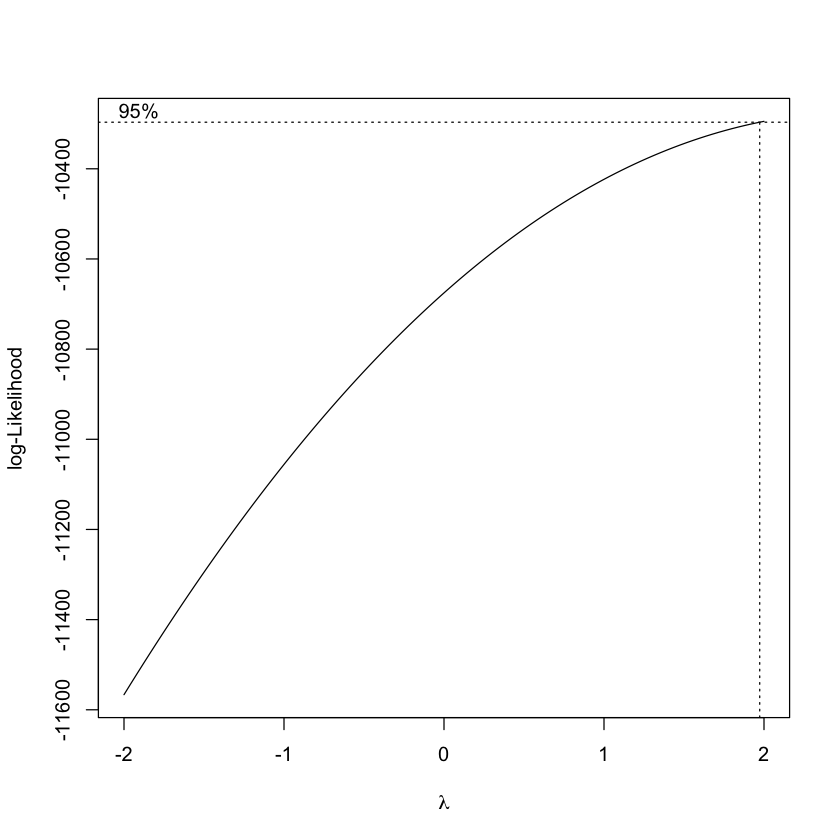

In [112]:
model9 <- lm(BMXHT ~ BMXLEG, data=bmx_d)
boxcox(model9, plotit=TRUE)

### Evaluation Metrics

There are multiple ways we could use to evaluate the performace of our model

##### Getting the predicted value

In [136]:
bmx_clean <- dplyr::select(bmx_d, c(BMXHT, BMXLEG)) 
bmx_clean <- na.omit(bmx_clean) # drop NA column

model10 <- lm(bmx_clean$BMXHT ~ bmx_clean$BMXLEG, data=bmx_clean)

predicted <- predict(model10)
predicted

2        3        5        6        7        8       10       12 
161.5020 173.4599 162.4398 168.0671 165.2535 170.6463 179.3216 168.7705 
      13       14       16       17       18       19       21       22 
167.1292 169.9429 188.4659 167.8326 160.0951 150.2474 168.0671 156.8126 
      23       24       25       26       27       28       29       30 
173.4599 154.2334 152.5921 158.9228 161.9709 174.6322 164.7845 151.8887 
      31       32       33       34       35       36       37       39 
175.1012 153.5300 155.8747 155.4058 153.0611 179.7906 164.7845 176.5080 
      40       43       44       45       48       50       51       52 
178.8527 167.5982 153.9989 148.3717 163.8467 171.8186 169.4739 169.4739 
      53       54       56       59       60       61       62       64 
163.1432 182.3697 167.5982 157.7505 172.2875 155.4058 164.0811 160.0951 
      65       66       67       68       71       73       75       76 
155.4058 141.3376 162.6743 170.4118 169.0050 172.2875 149.5440 165.9569 
      77       78       79       80       82       83       85       86 
156.8126 170.1773 157.2815 168.3016 161.9709 159.8607 170.6463 145.7925 
      87       90       91       92       93       95       96       97 
148.1372 170.6463 149.5440 170.6463 143.6823 170.4118 149.5440 157.0470 
      98       99      100      102      103      104      107      109 
158.9228 172.2875 159.1573 144.6202 169.0050 166.6603 167.1292 172.5220 
     110      111      112      113      114      115      116      117 
153.5300 172.9910 158.2194 158.6883 163.1432 180.0250 154.7024 172.2875 
     119      120      121      123      124      125      127      128 
164.7845 169.9429 156.5781 178.3837 161.5020 157.0470 177.6803 172.7565 
     129      131      132      133      134      136      137      138 
165.4879 168.3016 171.1152 160.0951 173.2254 160.3296 163.8467 150.0130 
     139      140      141      142      143      145      146      147 
158.9228 160.0951 162.4398 168.5360 173.9288 158.2194 183.5421 156.5781 
     148      149      150      153      154      155      157      158 
162.4398 159.6262 161.2675 162.6743 160.0951 167.3637 179.0872 157.0470 
     159      160      161      162      163      164      166      167 
153.0611 185.4178 162.2054 169.4739 154.4679 161.5020 162.4398 157.0470 
     168      169      170      171      172      173      174      176 
157.2815 163.6122 164.5501 168.3016 156.8126 169.4739 170.1773 155.4058 
     177      178      179      180      181      182      183      185 
173.6944 164.7845 175.1012 166.6603 155.4058 151.1853 181.1974 157.0470 
     186      188      189      190      192      193      194      198 
174.1633 147.9027 172.5220 160.5641 170.6463 160.0951 172.2875 161.9709 
     199      201      202      203      205      206      208      210 
164.7845 189.6383 155.8747 155.4058 165.0190 168.0671 146.7304 162.2054 
     211      212      213      214      216      217      218      219 
151.1853 163.6122 157.5160 169.4739 162.4398 177.6803 159.6262 166.4258 
     221      223      224      226      227      228      230      231 
160.7986 153.5300 164.5501 164.3156 160.7986 165.9569 169.2394 167.1292 
     233      235      236      237      238      240      241      243 
156.8126 166.4258 177.4459 168.5360 171.5841 147.1993 146.9649 153.9989 
     244      245      246      247      248      249      251      252 
156.1092 167.5982 161.7364 175.3356 163.8467 160.5641 168.3016 169.9429 
     253      254      256      258      259      260      261      262 
155.8747 153.2955 198.0792 177.4459 165.4879 157.0470 165.2535 150.7164 
     263      264      266      267      270      271      274      277 
168.3016 155.8747 155.6402 162.9088 166.1913 142.5100 179.5561 168.3016 
     279      280      281      282      284      287      289      290 
155.4058 157.0470 153.9989 151.4198 168.7705 164.5501 160.0951 150.7164 
     291      292      293      294      295      296      298   

##### MAE

MAE measures the average absolute difference between the predicted values and the actual values. It provides a straightforward way to assess the average magnitude of errors in a predictive model. MAE is less sensitive to outliers compared to other error metrics such as MSE. It is commonly used in regression and forecasting tasks to quantify the average deviation between predicted and observed values.

In [139]:
mae <- mean(abs(bmx_clean$BMXHT - predicted))
mae

[1] 6.320557

##### MSE

MSE calculates the average of the squared differences between predicted values and actual values. It is widely used as an error metric for regression tasks. Squaring the errors amplifies larger errors, making MSE more sensitive to outliers than MAE. MSE is often used in model training as an objective function to be minimized, and it provides a measure of the average variance between predicted and observed values.

In [141]:
mse <- mean((bmx_clean$BMXHT- predicted)^2)
mse

[1] 63.73224

##### AIC

AIC is a criterion used for model selection, especially in the context of statistical modeling. It balances the trade-off between model complexity and goodness of fit. AIC takes into account both the goodness of fit (captured by the likelihood of the model) and the complexity of the model (captured by the number of parameters used). Lower AIC values indicate a better trade-off between model complexity and fit. It is often used in regression, time series analysis, and other statistical modeling tasks.

In [142]:
AIC(model10)

[1] 51086.71

##### BIC

BIC, similar to AIC, is a criterion used for model selection. It provides a more stringent penalty for model complexity compared to AIC. BIC incorporates the likelihood of the model, the number of parameters used, and the sample size. BIC tends to penalize more complex models compared to AIC, which makes it useful for preventing overfitting. Lower BIC values indicate better-fitting models. Like AIC, BIC is commonly used in regression, time series analysis, and other statistical modeling tasks.

In [143]:
BIC(model10)

[1] 51107.4

### Feature Selection 

When there are a lot of variables to choose from, there are multiple ways we could choose which features to use 

In [158]:
bmx_clean2 <- dplyr::select(bmx_d, c(BMXHT, BMXLEG, BMXARMC, BMXARML, BMXBMI, BMXWAIST, BMXWT)) 
bmx_clean2 <- na.omit(bmx_clean2) # drop NA column
dim(bmx_clean2)

[1] 7259    7

In [163]:
fit.all <- lm(bmx_clean2$BMXHT ~ ., data = bmx_clean2)
intercept_only <- lm(bmx_clean2$BMXHT ~ 1, data = bmx_clean2)

##### forward selection

In [164]:
step(intercept_only, direction = 'forward', scope=formula(fit.all))

Start:  AIC=37081.8
bmx_clean2$BMXHT ~ 1

           Df Sum of Sq     RSS   AIC
+ BMXARML   1    927127  273208 26340
+ BMXLEG    1    738083  462252 30157
+ BMXWT     1    496972  703363 33204
+ BMXARMC   1    302927  897408 34973
+ BMXWAIST  1    232371  967964 35522
+ BMXBMI    1     88551 1111785 36528
<none>                  1200335 37082

Step:  AIC=26339.6
bmx_clean2$BMXHT ~ BMXARML

           Df Sum of Sq    RSS   AIC
+ BMXLEG    1     68484 204725 24247
+ BMXBMI    1     25836 247372 25620
+ BMXWAIST  1     10861 262347 26047
+ BMXARMC   1      7835 265373 26130
<none>                  273208 26340
+ BMXWT     1        18 273190 26341

Step:  AIC=24246.88
bmx_clean2$BMXHT ~ BMXARML + BMXLEG

           Df Sum of Sq    RSS   AIC
+ BMXBMI    1    6209.6 198515 24025
+ BMXWT     1    1749.7 202975 24187
+ BMXARMC   1     751.0 203974 24222
<none>                  204725 24247
+ BMXWAIST  1      32.3 204692 24248

Step:  AIC=24025.29
bmx_clean2$BMXHT ~ BMXARML + BMXLEG + BMXBMI




Call:
lm(formula = bmx_clean2$BMXHT ~ BMXARML + BMXLEG + BMXBMI + BMXWT + 
    BMXARMC + BMXWAIST, data = bmx_clean2)

Coefficients:
(Intercept)      BMXARML       BMXLEG       BMXBMI        BMXWT      BMXARMC  
  113.39658      0.96403      0.30925     -2.35430      0.75539      0.22378  
   BMXWAIST  
    0.04897  


##### backward selection

In [165]:
backward <- step(fit.all, direction='backward')

Start:  AIC=17018.07
bmx_clean2$BMXHT ~ BMXLEG + BMXARMC + BMXARML + BMXBMI + BMXWAIST + 
    BMXWT

           Df Sum of Sq    RSS   AIC
<none>                   75545 17018
- BMXWAIST  1       596  76140 17073
- BMXARMC   1      1163  76708 17127
- BMXLEG    1      4423  79968 17429
- BMXARML   1     17623  93168 18538
- BMXWT     1     91239 166784 22765
- BMXBMI    1    100420 175965 23154


##### both

In [167]:
backward <- step(fit.all, direction='both')

Start:  AIC=17018.07
bmx_clean2$BMXHT ~ BMXLEG + BMXARMC + BMXARML + BMXBMI + BMXWAIST + 
    BMXWT

           Df Sum of Sq    RSS   AIC
<none>                   75545 17018
- BMXWAIST  1       596  76140 17073
- BMXARMC   1      1163  76708 17127
- BMXLEG    1      4423  79968 17429
- BMXARML   1     17623  93168 18538
- BMXWT     1     91239 166784 22765
- BMXBMI    1    100420 175965 23154
